Install packages

In [1]:
# !git clone https://github.com/stefanknegt/Probabilistic-Unet-Pytorch.git

In [2]:
import sys
sys.path.append('Probabilistic-Unet-Pytorch/')

Download seismic and interpretations:

In [3]:
import numpy as np
import random
from datetime import datetime
import matplotlib.pyplot as plt

from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation
from tqdm.auto import tqdm, trange

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

Overall parametrization

In [4]:
lr = 1e-5
epochs = 1000
save_every_steps = 5
batch_size = 16

# Architecture parameters:
beta = 30.0
no_convs_fcomb = 2
latent_dim = 4
num_filters = [8,16,32,64]

This is Xinming Wu's keras dataloader:

In [5]:
import os
class MyDataset(Dataset):
    def __init__(self, dpath,fpath, dim = (128, 128, 128)):
        self.dpath = dpath
        self.fpath = fpath
        self.dim = dim
        dpath_files = os.listdir(dpath)
        fpath_files = os.listdir(fpath)
        assert dpath_files == fpath_files
        self.volumes = []
        for fname in dpath_files:
            d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
            f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
            d = d.reshape(1, *dim)
            f = f.reshape(1, *dim)
            self.volumes.append([d, f])
    def __len__(self):
        return len(self.volumes)
    def __getitem__(self, i):
        x, y = self.volumes[i]
        iln = np.random.choice(self.dim[0])
        x = x[:, iln]
        y = y[:, iln]
        return x, y

In [6]:
# import os
# class MyDataset(Dataset):
#     def __init__(self, dpath,fpath, dim = (128, 128, 128)):
#         self.dpath = dpath
#         self.fpath = fpath
#         self.dim = dim
#         dpath_files = os.listdir(dpath)
#         fpath_files = os.listdir(fpath)
#         assert dpath_files == fpath_files
#         self.dpath_files = dpath_files
#     def __len__(self):
#         return len(self.dpath_files)
#     def __getitem__(self, i):
#         fname = self.dpath_files[i]
#         d = np.fromfile(os.path.join(self.dpath, fname),dtype=np.single)
#         f = np.fromfile(os.path.join(self.fpath, fname),dtype=np.single)
#         x = d.reshape(1, *self.dim)
#         y = f.reshape(1, *self.dim)
#         iln = np.random.choice(self.dim[0])
#         x = x[:, iln]
#         y = y[:, iln]
#         return x, y

In [7]:
seismPathT = "./data/train/seis/"
faultPathT = "./data/train/fault/"

seismPathV = "./data/validation/seis/"
faultPathV = "./data/validation/fault/"

train_generator = MyDataset(dpath=seismPathT,fpath=faultPathT)
valid_generator = MyDataset(dpath=seismPathV,fpath=faultPathV)

In [8]:
x, y = train_generator[0]
x.shape

(1, 128, 128)

In [9]:
train_loader = DataLoader(train_generator, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(valid_generator, batch_size = batch_size, shuffle = True)

In [10]:
x, y = next(iter(train_loader))
x.shape

torch.Size([16, 1, 128, 128])

Now I try to load it with the pytorch dataloader:

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is', device)

device is cuda


In [12]:
class Logger(object):
    def __init__(self):
        self.metrics = ['elbo', 'reconstruction_loss', 'mse_loss', 'std', 'kl divergence', 'reg_loss']
        self.lists = [[], [], [], [], [], []]
        self.steps = []
    def step(self, global_step, *args):
        for i, value in enumerate(args):
            self.lists[i].append(value.item())
        self.steps.append(global_step)

Here we need to adjust the dimensions:

In [13]:
net = ProbabilisticUnet(input_channels=1, 
                        num_classes=1, 
                        num_filters=num_filters, 
                        latent_dim=latent_dim, 
                        no_convs_fcomb=no_convs_fcomb, 
                        beta=beta)
net = net.to(device)

In [14]:
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)
net(x, y, training=True)
net.elbo(y)

/usr/local/anaconda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(-357809.4375, device='cuda:0', grad_fn=<NegBackward0>)

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=0)
global_step = 0
nsamples = 64
mse_criteria = nn.MSELoss()
logger = Logger()
loggerVal = Logger()

def compute_stats(mask):
    mean_pred = torch.zeros_like(mask)
    mean_sq_pred = torch.zeros_like(mask)
    for _ in range(nsamples):
        pred = net.sample().detach()
        mean_pred += pred
        mean_sq_pred += pred**2
    mean_pred /= nsamples
    mean_sq_pred /= nsamples
    var_pred = (mean_sq_pred - mean_pred**2)
    mse = mse_criteria(mask, mean_pred)
    std = var_pred.mean()**0.5
    return mse, std
for epoch in trange(epochs, desc = 'epochs'):
    for step in trange(len(train_loader), desc='batches', leave=False):
        patch, mask = next(iter(train_loader))
        patch = patch.to(device)
        mask = mask.to(device)
        net(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if global_step % save_every_steps == 0:
            mse, std = compute_stats(mask)
            logger.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
            
            patch, mask = next(iter(val_loader))
            patch = patch.to(device)
            mask = mask.to(device)
            net(patch, mask, training=False)
            elbo = net.elbo(mask).detach()
            reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
            loss = -elbo + 1e-5 * reg_loss
            mse, std = compute_stats(mask)
            loggerVal.step(global_step, elbo, net.reconstruction_loss, mse, std, net.kl, reg_loss)
        global_step += 1

epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

batches:   0%|          | 0/13 [00:00<?, ?it/s]

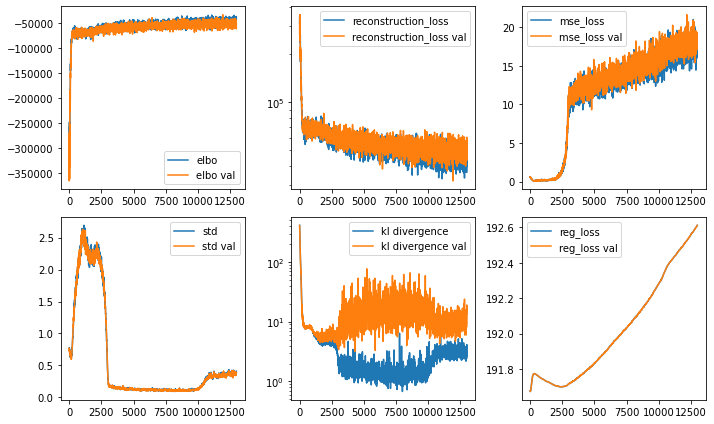

In [16]:
ncols = 3
nrows = len(logger.metrics) // ncols
fig, axs = plt.subplots(figsize = (10, 6), ncols = ncols, nrows = nrows)
for i, name in enumerate(logger.metrics):
    axs.flatten()[i].plot(logger.steps, logger.lists[i], label = name)
    axs.flatten()[i].plot(loggerVal.steps, loggerVal.lists[i], label = name+' val')
    if name in ['kl divergence', 'reconstruction_loss']:
        axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].legend()
plt.tight_layout()

In [17]:
patch, mask = next(iter(train_loader))
net.forward(patch.to(device), None, training=False)

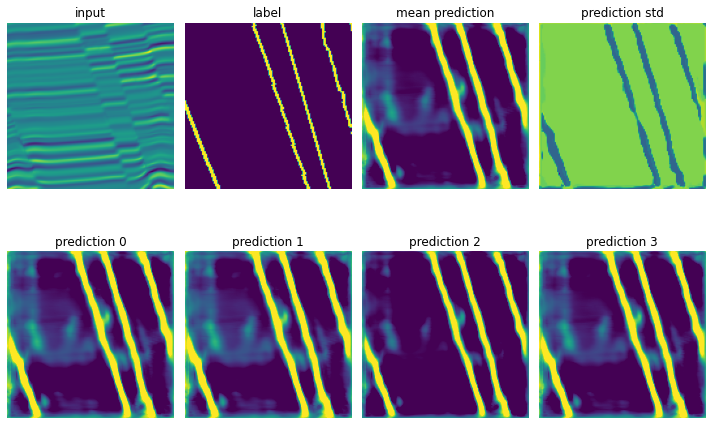

In [18]:
i = np.random.randint(batch_size)

nsamples = 4
ncols = 4
nrows = int(np.ceil((nsamples+3) / ncols))

pred_mask = net.sample().detach().cpu()
vmin = torch.quantile(pred_mask, 0.1)
vmax = torch.quantile(pred_mask, 0.9)

fig, axs = plt.subplots(figsize = (10, 7), ncols = ncols, nrows = nrows)
axs.flatten()[0].imshow(patch[i,0].T)
axs.flatten()[0].axis('off')
axs.flatten()[0].set_title('input')
axs.flatten()[1].imshow(mask[i,0].T)
axs.flatten()[1].axis('off')
axs.flatten()[1].set_title('label')

mean_pred = torch.zeros_like(mask)
mean_sq_pred = torch.zeros_like(mask)
for j in range(nsamples):
    pred_mask = net.sample().detach().cpu()
    mean_pred += pred_mask
    mean_sq_pred += pred_mask**2
    axs.flatten()[j+4].imshow(pred_mask[i,0].T, vmin = vmin, vmax = vmax)
    axs.flatten()[j+4].axis('off')
    axs.flatten()[j+4].set_title(f'prediction {j:d}')
mean_pred /= nsamples
mean_sq_pred /= nsamples
var_pred = (mean_sq_pred - mean_pred**2)
std = var_pred**0.5


axs.flatten()[2].imshow(mean_pred[i,0].T, vmin = vmin, vmax = vmax)
axs.flatten()[2].axis('off')
axs.flatten()[2].set_title(f'mean prediction')

axs.flatten()[3].imshow(std[i,0].T)
axs.flatten()[3].axis('off')
axs.flatten()[3].set_title(f'prediction std')

plt.tight_layout()